In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import re


def clean_array(data):
    """Helper function to clean any deprecated JAX arrays."""
    if isinstance(data, np.ndarray):
        return np.array(data)  # Ensure the array doesn't have deprecated attributes
    elif isinstance(data, dict):
        return {k: clean_array(v) for k, v in data.items()}
    elif isinstance(data, list):
        return [clean_array(v) for v in data]
    else:
        return data

def debug_print(message, variable=None):
    """Debug function to log paths and data states."""
    if variable is not None:
        print(f"[DEBUG] {message}: {variable}")
    else:
        print(f"[DEBUG] {message}")

def is_valid_pickle_file(file_path):
    """Function to validate pickle files."""
    try:
        if file_path.exists() and file_path.stat().st_size > 0:
            with open(file_path, 'rb') as f:
                df = pickle.load(f)
            return True
        else:
            return False
    except EOFError:
        return False

def extract_last_number(text):
    """Extract last number from a string."""
    numbers = re.findall(r'\d+', text)
    return int(numbers[-1]) if numbers else 0



def read_jax_file(file_path):
    """Read and parse the JAX pickle file."""
    with open(file_path, 'rb') as f:
        df = pickle.load(f)
        df = clean_array(df)

        costs = np.asarray(df['costs'][0], dtype=np.float64)
        grads_per_epoch = [np.asarray(grad, dtype=np.float64) for grad in df['grads_per_epoch'][0]]
        fidelity = df['avg_fidelity'][0]
        total_params = 3 + int(df['controls'][0]) * int(df['reservoirs'][0]) * int(df['trotter_step'][0]) +  int(df['trotter_step'][0])
        test_results = np.asarray(df['testing_results'][0], dtype=np.float64)
        bath_params = {
            'gamma_scale': df['gamma_scale'][0],
            'lambda_scale': df['lambda_scale'][0],
            'bath_factor': df['bath_factor'][0]
        }

        return costs, fidelity, total_params, test_results, grads_per_epoch, bath_params
# Main extraction loop
N_ctrls = [1]
train_sizes = {1: 10}
num_epochs = 1000
optimal_min_error = 1e-9
optimal_jitter_scale = 1e-10
base_path = './analog_results_trainable_baths/'
rows = []
selected_bath_factors = [1.0]
selected_gamma_scales =[0.05, 0.1]
selected_lambda_scales =  [0.01,0.1]

for N_ctrl in N_ctrls:
    training_size = train_sizes[N_ctrl]
    training_folder = f'trainsize_{training_size}_epoch{num_epochs}'

    for bath_factor in selected_bath_factors:
        bath_folder_path = os.path.join(base_path, training_folder, f'bath_factor_{bath_factor}')
        if not os.path.exists(bath_folder_path):
            continue

        gamma_folders = sorted(
            [d for d in os.listdir(bath_folder_path) if d.startswith('gamma_') and float(d.split('_')[1]) in selected_gamma_scales]
        )

        for gamma_folder in gamma_folders:
            lambda_folders = sorted(
                [d for d in os.listdir(os.path.join(bath_folder_path, gamma_folder)) if d.startswith('lambda_') and float(d.split('_')[1]) in selected_lambda_scales]
            )

            for lambda_folder in lambda_folders:
                folder_path = os.path.join(bath_folder_path, gamma_folder, lambda_folder)

                for num_bath in range(3):  # Assuming baths are numbered as 0, 1, 2
                    bath_folder = os.path.join(folder_path, f'{num_bath}_num_baths/')

                    # Check if the bath folder exists for num_bath
                    if not os.path.exists(bath_folder):
                        print(f"[WARNING] Bath folder for num_bath={num_bath} does not exist: {bath_folder}")
                        continue

                    has_data = False  # Track if there is data for this bath

                    for gate_folder in sorted(os.listdir(bath_folder)):
                        if gate_folder.startswith(f'U{N_ctrl}_'):
                            gate_path = os.path.join(bath_folder, gate_folder)

                            for reservoir_folder in sorted(os.listdir(gate_path), key=extract_last_number):
                                if 'reservoirs_' in reservoir_folder:
                                    reservoir_count = extract_last_number(reservoir_folder)
                                    reservoir_path = os.path.join(gate_path, reservoir_folder)

                                    for trot_folder in sorted(os.listdir(reservoir_path), key=extract_last_number):
                                        if 'trotter_step_' in trot_folder:
                                            trotter_step = extract_last_number(trot_folder)
                                            trotter_path = os.path.join(reservoir_path, trot_folder)

                                            files_in_folder = os.listdir(trotter_path)
                                            current_best_fidelity = float('-inf')  # Set initial best fidelity as lowest possible value
                                            current_best_data_point = None
                                            num_data_runs = 0

                                            for file in files_in_folder:
                                                if not file.startswith('.') and file.endswith('.pickle'):
                                                    pickle_file = os.path.join(trotter_path, file)

                                                    if is_valid_pickle_file(Path(pickle_file)):
                                                          # Data exists for this bath
                                                        costs, fidelity, total_params, test_results, grads_per_epoch, bath_params = read_jax_file(pickle_file)
                                                        num_data_runs += 1  # Increment the number of data runs
                                                        run = os.path.basename(pickle_file).replace('.pickle', '')

                                                        if fidelity > current_best_fidelity:
                                                            has_data = True
                                                            current_best_fidelity = fidelity
                                                            fidelities, infidelities, log_infidelities = [], [], []
                                                            for i, fidelity in enumerate(test_results):
                                                                fidelity = np.clip(fidelity, 0.0, 1.0)  # Ensure fidelity is within [0, 1]
                                                                infidelity = 1.0 - fidelity
                                                                if infidelity <= 0:
                                                                    # Numerical error, apply clipping with dynamically determined values
                                                                    jitter = np.random.uniform(-optimal_jitter_scale, optimal_jitter_scale)
                                                                    infidelity = optimal_min_error + jitter
                                                                    assert infidelity > 0, f"Adjusted infidelity is non-positive. Index: {i}, min error: {optimal_min_error} Jitter: {optimal_jitter_scale}."
                                                                    fidelity = 1.0 - infidelity

                                                                fidelities.append(fidelity)
                                                                infidelities.append(infidelity)
                                                                log_infidelities.append(np.log10(infidelity))

                                                            avg_fidelity = np.mean(fidelities)
                                                            avg_infidelity = np.mean(infidelities)
                                                            std_fidelity = np.std(fidelities)

                                                            if num_bath == 0:
                                                                bath_params['gamma_scale'] = float(gamma_folder.split('_')[1])
                                                                bath_params['lambda_scale'] = float(lambda_folder.split('_')[1])

                                                            current_best_data_point = {
                                                                'N_C': N_ctrl,
                                                                'Gate': gate_folder,
                                                                'Bath_Factor': bath_factor,
                                                                'Bath': num_bath,
                                                                'Reservoirs': reservoir_count,
                                                                'Trotter_Step': trotter_step,
                                                                'Avg_Fidelity': avg_fidelity,
                                                                'Std_Fidelity': std_fidelity,
                                                                'Avg_Infidelity': avg_infidelity,
                                                                'Var_Infidelity': np.var(infidelities),
                                                                'Costs': costs,
                                                                'Infidelities': infidelities,
                                                                'fidelities': fidelities,
                                                                'Param_Count': total_params,
                                                                'Run': run,
                                                                'Error_Test_Results': log_infidelities,
                                                                'Bath_Params': bath_params,
                                                                'gamma_scale': float(gamma_folder.split('_')[1]),
                                                                'lambda_scale': float(lambda_folder.split('_')[1])
                                                            }


                                            if current_best_data_point:
                                                rows.append(current_best_data_point)

                    if not has_data and num_bath == 0:
                        print(f"[ERROR] No data found for num_bath={num_bath} in path: {bath_folder}")

# Create a DataFrame from rows
all_data_df = pd.DataFrame(rows)

In [5]:
all_data_df['gamma_scale'].unique()

array([0.05, 0.1 ])

In [2]:
# print(len(all_data_df[(all_data_df['Bath'] == 1) & (all_data_df['lambda_scale']!=0.05)]))
all_data_df[(all_data_df['Bath'] >=0) & (all_data_df['Trotter_Step'] == 3) & (all_data_df['lambda_scale']==0.1) & (all_data_df['Avg_Fidelity'] < 0.8)].head()

,N_C,Gate,Bath_Factor,Bath,Reservoirs,Trotter_Step,Avg_Fidelity,Std_Fidelity,Avg_Infidelity,Var_Infidelity,Costs,Infidelities,fidelities,Param_Count,Run,Error_Test_Results,Bath_Params,gamma_scale,lambda_scale


Unique combinations of gamma_scale and lambda_scale: [(0.05, 0.01), (0.05, 0.1), (0.1, 0.01), (0.1, 0.1)]
Subset for Bath = 0 exists in the data being plotted.
Subset for Bath = 0 exists in the data being plotted.
Subset for Bath = 0 exists in the data being plotted.
Subset for Bath = 0 exists in the data being plotted.


/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_86280/1885806901.py:118: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


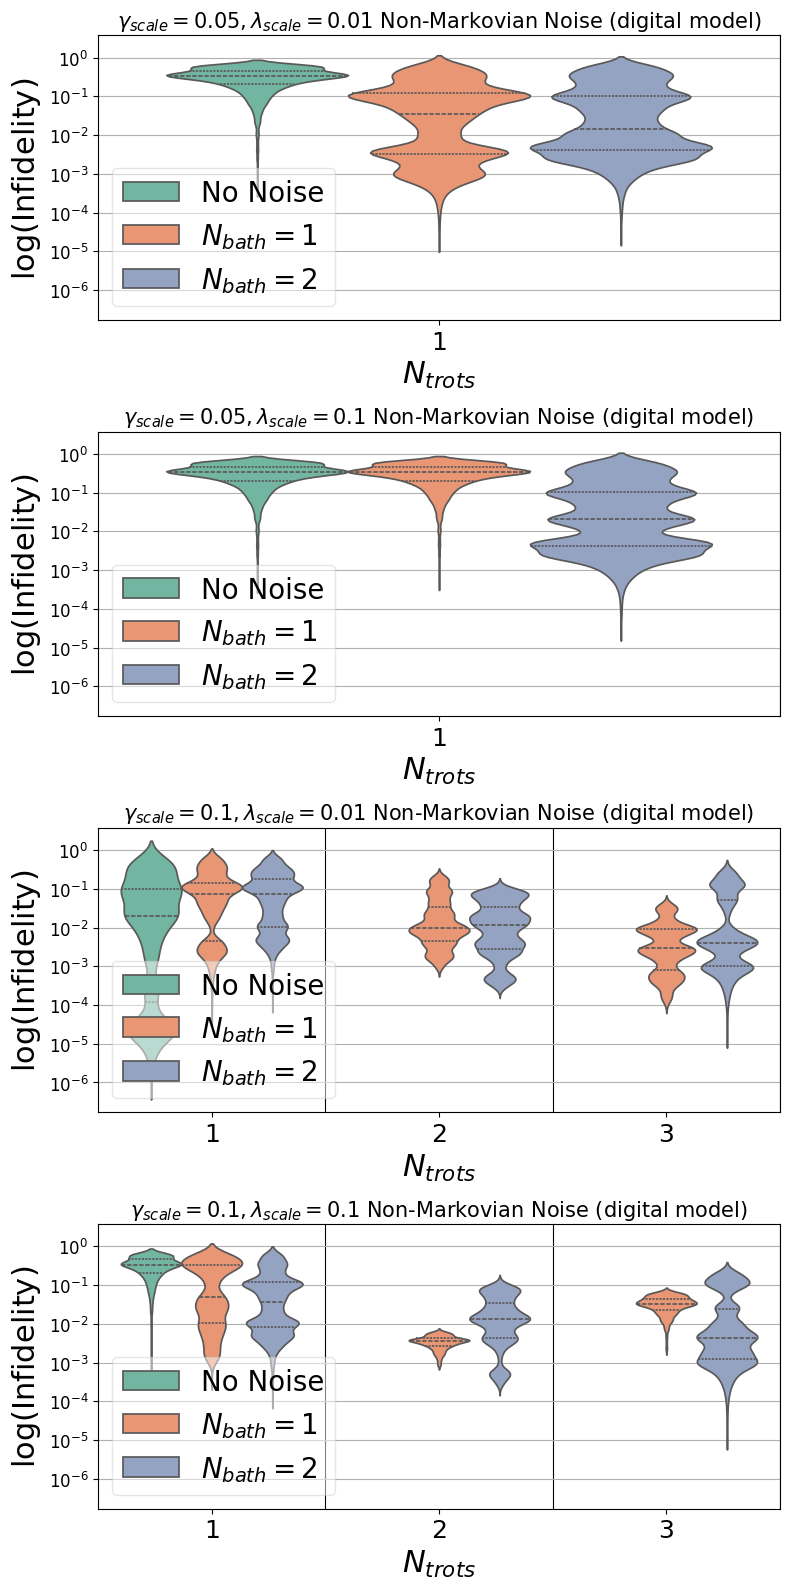

In [6]:
def plot_infidelity_by_scales(data_df, N_C=1, trotter_steps=None, bath_factors=None, gamma_scales=None, lambda_scales=None):
    """
    Plot infidelity (log scale) for specific combinations of bath_factors, gamma_scales, and lambda_scales,
    including the case for no noise (N_bath = 0).

    Args:
        data_df (DataFrame): The DataFrame containing extracted data.
        N_C (int): The number of control qubits to filter the data by.
        trotter_steps (list): A list of specific trotter steps to filter and plot. If None, all steps are used.
        bath_factors (list): List of bath factors to filter data by. If None, all are used.
        gamma_scales (list): List of gamma scales to filter data by. If None, all are used.
        lambda_scales (list): List of lambda scales to filter data by. If None, all are used.
    """
    # Filter data by N_C
    data_Nc = data_df[data_df['N_C'] == N_C]

    # Filter by trotter_steps
    if trotter_steps:
        data_Nc = data_Nc[data_Nc['Trotter_Step'].isin(trotter_steps)]

    # Filter by bath_factors (if necessary)
    if bath_factors:
        data_Nc = data_Nc[data_Nc['Bath_Factor'].isin(bath_factors)]

    if gamma_scales:
        data_Nc = data_Nc[data_Nc['gamma_scale'].isin(gamma_scales)]
        # print(f"Data after filtering by gamma_scales={gamma_scales}:")
        # print(data_Nc[['N_C', 'Bath', 'Trotter_Step', 'gamma_scale', 'lambda_scale']].drop_duplicates())


    # Filter by lambda_scales
    if lambda_scales:
        data_Nc = data_Nc[data_Nc['lambda_scale'].isin(lambda_scales)]

    # Get unique combinations of gamma_scale and lambda_scale
    # Get unique combinations of gamma_scale and lambda_scale
    unique_combinations = data_Nc.groupby(['gamma_scale', 'lambda_scale']).size().index.tolist()
    print(f"Unique combinations of gamma_scale and lambda_scale: {unique_combinations}")

    # Create subplots for each unique combination
    nrows = len(unique_combinations)
    # fig, axes = plt.subplots(
    #     nrows=nrows, figsize=(8, 4 * nrows), sharex=True, sharey=True, constrained_layout=True
    # )
    fig, axes = plt.subplots(
        nrows=nrows, figsize=(8, 4 * nrows), sharey=True, constrained_layout=True
    )

    # Ensure axes is always iterable
    if nrows == 1:
        axes = [axes]

    # Iterate over each unique combination and plot
    for ax, (gamma_scale, lambda_scale) in zip(axes, unique_combinations):
        df_to_plot = data_Nc[
            (data_Nc['gamma_scale'] == gamma_scale) & (data_Nc['lambda_scale'] == lambda_scale)
        ]

        all_test_results = df_to_plot.explode('Error_Test_Results').reset_index()
        all_test_results['Log(Infidelity)'] = all_test_results['Error_Test_Results']

        # Ensure the Bath column includes "No Noise" (N_bath = 0)
        all_test_results['Bath'] = all_test_results['Bath'].fillna(0).astype(int)

        # Add vertical strips of color for trotter steps
        unique_trotter_steps = sorted(all_test_results['Trotter_Step'].unique())
        positions = range(1, len(unique_trotter_steps) + 1)
        for i, pos in enumerate(positions):
            ax.axvline(x=pos - 0.5, color='black', linestyle='-', linewidth=0.8, zorder=0)
        # Check if the subset of data passed to the plotting function contains Bath = 0
        subset = all_test_results[all_test_results['Bath'] == 0]
        if subset.empty:
            print("Subset for Bath = 0 is empty!")
        else:
            print("Subset for Bath = 0 exists in the data being plotted.")
        sns.violinplot(
            x='Trotter_Step',
            y='Log(Infidelity)',
            hue='Bath',
            data=all_test_results,
            ax=ax,
            density_norm='width',
            palette='Set2',
            inner="quart",
            zorder=2
        )

        # Customize legend
        handles, labels = ax.get_legend_handles_labels()
        new_labels = ['No Noise' if int(label) == 0 else f'$N_{{bath}} = {label}$' for label in labels]
        ax.legend(handles, new_labels, title_fontsize=16, loc='lower left', fontsize=20, fancybox=True, framealpha=0.5)

        # Customize grid and title
        ax.yaxis.grid(True, zorder=1)
        ax.xaxis.grid(False)

        ax.set_title(
            f'$\\gamma_{{scale}} = {gamma_scale}, \\lambda_{{scale}} = {lambda_scale}$ Non-Markovian Noise (digital model)',
            fontsize=15
        )
        ax.set_xlabel('$N_{trots}$', fontsize=22)
        ax.set_ylabel(r'$\log(\text{Infidelity})$', fontsize=22)

        # Adjust Y-ticks for log scale
        y_ticks = ax.get_yticks()
        whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
        min_tick = min(whole_y_ticks)
        max_tick = max(whole_y_ticks)
        whole_y_ticks = np.arange(min_tick, max_tick + 1, 1)

        ax.set_yticks(whole_y_ticks)
        ax.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

        # Adjust tick sizes
        ax.tick_params(axis='y', labelsize=12)
        ax.tick_params(axis='x', labelsize=18)

    plt.tight_layout()
    plt.show()

# Example call
plot_infidelity_by_scales(
    all_data_df,
    N_C=1,
    trotter_steps=[1,2,3],
    bath_factors=[1.0],
    gamma_scales=[0.05,0.1],
    lambda_scales=[0.01, 0.1]
)

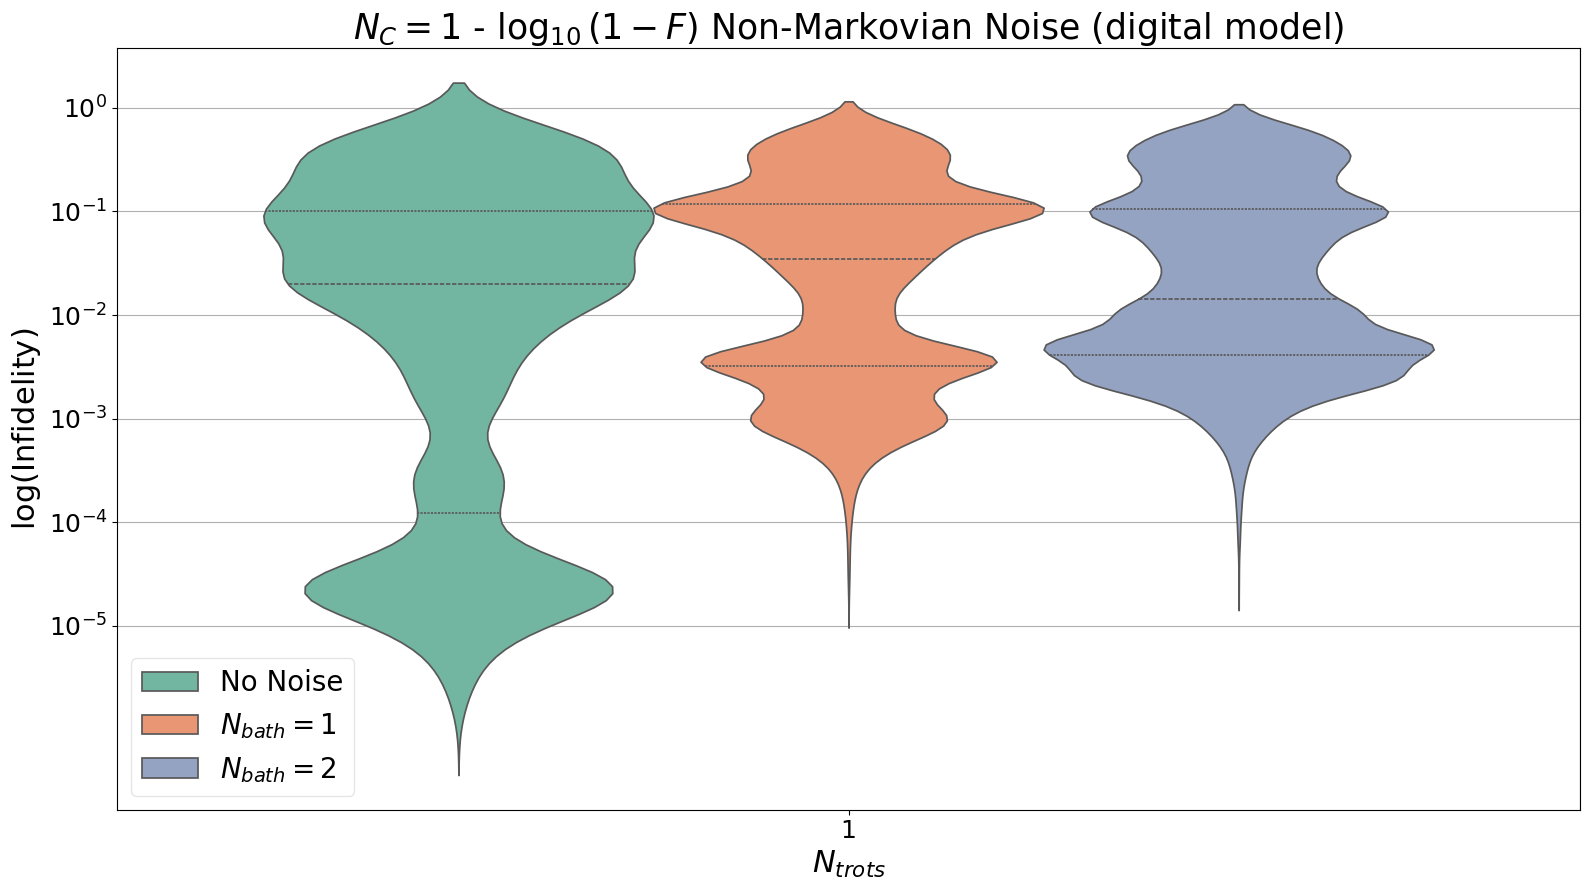

In [3]:
data_Nc_1 = all_data_df[all_data_df['N_C'] == 1]
# data_Nc_2 = all_data_df[all_data_df['N_C'] == 2]
df_to_plot = data_Nc_1
# Create a violin plot based on the new DataFrame
fig, ax = plt.subplots(figsize=(16, 9))


all_test_results = df_to_plot.explode('Error_Test_Results').reset_index()
all_test_results['Log(Infidelity)'] = all_test_results['Error_Test_Results']

# Add vertical strips of color
unique_trotter_steps = sorted(all_test_results['Trotter_Step'].unique())
positions = range(1, len(unique_trotter_steps) + 1)
for i, pos in enumerate(positions):
    ax.axvline(x=pos - 0.5, color='black', linestyle='-', linewidth=0.8, zorder=0)

sns.violinplot(
    x='Trotter_Step',
    y='Log(Infidelity)',
    hue='Bath',
    data=all_test_results,
    ax=ax,
    # bw_adjust=0.5,
    density_norm='width',
    palette='Set2',
    inner="quart",
    zorder=2
)


# Customize legend
handles, labels = ax.get_legend_handles_labels()
new_labels = ['No Noise' if int(label) == 0 else f'$N_{{bath}} = {label}$' for label in labels]
legend = ax.legend(handles, new_labels, title_fontsize=16, loc='lower left', fontsize=20, fancybox=True, framealpha=0.5)

# Customize grid and title
ax.yaxis.grid(True, zorder=1)
ax.xaxis.grid(False)

ax.set_title(f'$N_C = {N_ctrl}$ - $\log_{{10}}(1 - F)$ Non-Markovian Noise (digital model)', fontsize=25)
ax.set_xlabel('$N_{trots}$', fontsize=22)
ax.set_ylabel(r'$\log(\text{Infidelity})$', fontsize=22)

# Adjust Y-ticks for log scale
y_ticks = ax.get_yticks()
whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
min_tick = min(whole_y_ticks)
max_tick = max(whole_y_ticks)
whole_y_ticks = np.arange(min_tick+2, max_tick + 1, 1)

ax.set_yticks(whole_y_ticks)
ax.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

# Adjust tick sizes
ax.tick_params(axis='y', labelsize=18)
ax.tick_params(axis='x', labelsize=18)

plt.tight_layout()
plt.show()
